# Electronic Computing Device Price Prediction Using Machine Learning
Author: Zhuo Fan Chen(P2100746) | Singapore Polytechnic

## Problem Statement
How can we make use of machine learning to help potential computer buyers and vendors to evaluate market price/worth of a computer?

## Problem Understanding

Before launch of an electronic computing product ,the specifications of the products are usually leaked out.With a price predictor,potential consumers will be able to know its estimate price and make a more informed decision when deciding whether to purchase the product.

Additionally,many computers buyers do not know the market price of the computer of that specification and bought the product from external vendors at an overpriced price.Therefore, a price predictor can allow these buyers to have a rough estimation on the average price of product of similar specifications and decide whether is it worth to make the purchase.


Lastly ,it also allows electronic product manufacture to have a rough estimate of the market price of this type of product.


A price of a computer may depend on many factors.Such factors include:Central unit processor(CPU),RAM size,brand etc.

In this investigation,we will evaluate a regression model that has the highest performance in predicting the price of computers based on the relevant features.


## Import Dependencies

In [5]:
!pip install numpy matplotlib pandas seaborn scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno tqdm mlxtend category-encoders

     |████████████████████████████████| 78 kB 6.1 MB/s eta 0:00:011


In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()

import phik
# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold
from yellowbrick.model_selection import learning_curve
from statsmodels.api import qqplot
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV, validation_curve, RandomizedSearchCV


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, VarianceThreshold, mutual_info_regression, RFE

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Data Ingestion

In [7]:
pcDf=pd.read_csv('./pc_data (regression).csv')
pcDf

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200
15316,15316,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600
15317,15317,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,616.82600
15318,15318,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600


At first glance,we observed:
- The product ID may not be useful in prediction since the product ID for every product is different
- There is missing data in some rows
- The naming of some data that supposed to be referring to the same thing are named differently.Example: For the macOS in the operating system feature ,some rows are named Mac OS X while other rows named macOS.
-Some features are containing too much information that should be split
- The data type for some features can be changed

## Data Exploration Analysis (EDA)
Before creating the machine learning model, we will carry out the Exploratory Data Analysis (EDA). The exploratory data analysis was proposed by Tukey (1977).It is an approach of analyzing data to gain further discoveries from data and provide a basis for further data preparation and experiment.

### Dataset Information
 This dataset was in xxx.This dataset consists of 1 target label(price) and 11 independent features.15,320 rows of data are found in this dataset.Therefore,we conclude that the size of the dataset is neither too small nor too big.

### Data Dictionary







### Data Structure

In [8]:
pcDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


By viewing the basic information of the dataset,we realised 2 problem
 - Some feature's data type is incorrect. (E.g. Features such as weight should be more appropriate in float64 form)
 - There is missing data but not identified by default Pandas.  (E.g. The data type of many features is object which is abnormal but total non-null count is still 15320.)

### Feature Engineering


#### Data Categorization

In [9]:
objectEngineer=['Brand','Type','Screen Specs','CPU','RAM','Hard Disk','GPU','Operating System','Weight']

In [10]:
from IPython.core.display_functions import display

for i in objectEngineer:
    display(pd.DataFrame(pd.unique(pcDf[i]),columns=[i]))

,Brand
0,Apple
1,HP
2,Acer
3,Asus
4,Dell
5,Lenovo
6,Chuwi
7,MSI
8,Microsoft
9,Toshiba


,Type
0,Ultrabook
1,Notebook
2,Netbook
3,Gaming
4,2 in 1 Convertible
5,Workstation


,Screen Specs
0,IPS Panel Retina Display 2560x1600
1,1440x900
2,Full HD 1920x1080
3,IPS Panel Retina Display 2880x1800
4,1366x768
5,IPS Panel Full HD 1920x1080
6,IPS Panel Retina Display 2304x1440
7,IPS Panel Full HD / Touchscreen 1920x1080
8,Full HD / Touchscreen 1920x1080
9,Touchscreen / Quad HD+ 3200x1800


,CPU
0,Intel Core i5 2.3GHz
1,Intel Core i5 1.8GHz
2,Intel Core i5 7200U 2.5GHz
3,Intel Core i7 2.7GHz
4,Intel Core i5 3.1GHz
...,...
113,Intel Celeron Dual Core N3350 2GHz
114,Samsung Cortex A72&A53 2.0GHz
115,AMD E-Series 9000 2.2GHz
116,Intel Core M 6Y30 0.9GHz


,RAM
0,8GB
1,16GB
2,4GB
3,2GB
4,12GB
5,6GB
6,32GB
7,24GB
8,64GB


,Hard Disk
0,128GB SSD
1,128GB Flash Storage
2,256GB SSD
3,512GB SSD
4,500GB HDD
5,256GB Flash Storage
6,1TB HDD
7,32GB Flash Storage
8,128GB SSD + 1TB HDD
9,256GB SSD + 256GB SSD


,GPU
0,Intel Iris Plus Graphics 640
1,Intel HD Graphics 6000
2,Intel HD Graphics 620
3,AMD Radeon Pro 455
4,Intel Iris Plus Graphics 650
...,...
105,Nvidia Quadro M500M
106,AMD Radeon R7 M360
107,Nvidia Quadro M3000M
108,Nvidia GeForce 960M


,Operating System
0,macOS
1,No OS
2,Windows 10
3,Mac OS X
4,Linux
5,Android
6,Windows 10 S
7,Chrome OS
8,Windows 7


,Weight
0,1.37kg
1,1.34kg
2,1.86kg
3,1.83kg
4,2.1kg
...,...
174,2.21kg
175,3.3kg
176,2.191kg
177,2.34kg


In [11]:
pcDf.Weight=pcDf.Weight.replace({'kg':''},regex=True)
pcDf.RAM=pcDf.RAM.replace({'GB':''},regex=True)


In [12]:
pcDf['Operating System']=pcDf['Operating System'].replace({'Windows 10 S':'Windows 10','Mac OS X':'macOS'},regex=True)
pcDf

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.8,1706.40200
15316,15316,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.3,4000.10600
15317,15317,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5,616.82600
15318,15318,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,2042.06600


In [13]:
pcDf['Hard Disk']=pcDf['Hard Disk'].replace({'TB':'000',"GB":'',},regex=True)
index=pcDf['Hard Disk'].index
testDf=pcDf.copy()
typeDisk=['SSD','Flash Storage','HDD','Hybrid']
diskDf=pd.DataFrame(0, columns=typeDisk, index=index)
for i,k in enumerate(testDf['Hard Disk']):
   flag1=0
   td=k

   for s in typeDisk:
       if s in k:
          test=td.split(' '+s,1)
          if any("+" in n for n in test):
              if not flag1:
                td=td.split('+ ',1)[1]
              flag1=1
          diskDf[s][i]+=int(float(test[0]))
pcDf=pd.concat([pcDf,diskDf],axis=1)


In [14]:
screenType=pcDf['Screen Specs'].apply(lambda x: pd.Series(['NA',x.rsplit(' ',1)[0]] if ('x' in x.rsplit(' ',1)[0]) else x.rsplit(' ',1)))
touch=pd.DataFrame([0 if (touch ==None) else 1 for touch in screenType[0].str.split(pat='Touchscreen',expand=True)[1]],columns=['Touchscreen'])

resolution=pd.DataFrame(screenType[1]).rename(columns={1:"Resolution"})

pcDf=pd.concat([pcDf,resolution,touch],axis=1)

#### Drop Redundant Features

In [15]:
pcDf=pcDf.drop(['Screen Specs','Hard Disk'],1)

/tmp/ipykernel_431208/1844799192.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pcDf=pcDf.drop(['Screen Specs','Hard Disk'],1)


In [16]:
pcDf=pcDf.astype({'Product ID':np.int64,'Brand':'U16','Type':'U32','Screen Size':'f8','CPU':'U32','RAM':np.int64,'GPU':'U32','Operating System':'U32','Weight':'f8','Resolution':'U32','Touchscreen':np.int64})

In [17]:
pcDf

,Product ID,Brand,Type,Screen Size,CPU,RAM,GPU,Operating System,Weight,Price ($),SSD,Flash Storage,HDD,Hybrid,Resolution,Touchscreen
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,128,0,0,0,2560x1600,0
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,0,128,0,0,1440x900,0
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,1531.80000,256,0,0,0,1920x1080,0
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,512,0,0,0,2880x1800,0
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,256,0,0,0,2560x1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,1706.40200,128,0,0,0,1920x1080,1
15316,15316,Lenovo,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,4000.10600,512,0,0,0,3200x1800,1
15317,15317,Lenovo,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,616.82600,0,64,0,0,1366x768,0
15318,15318,HP,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,2042.06600,0,0,1000,0,1366x768,0


#### Quantitative Features

In [18]:
quantitativeVariable=['Screen Size','RAM','Weight','Hybrid']

#### Qualitative Features

In [19]:
qualitativeVariable=['Brand','Type','CPU','GPU','Operating System','Resolution','SSD','HDD','Flash Storage']

### Univariate Analysis

#### Descriptive Statistics

In [20]:
pcDf[quantitativeVariable].describe()

,Screen Size,RAM,Weight,Hybrid
count,15320.000000,15320.000000,15320.000000,15320.000000
mean,15.016475,8.398433,2.040976,0.406527
std,1.425779,5.104099,0.668048,14.212510
min,10.100000,2.000000,0.690000,0.000000
25%,14.000000,4.000000,1.500000,0.000000
50%,15.600000,8.000000,2.040000,0.000000
75%,15.600000,8.000000,2.310000,0.000000
max,18.400000,64.000000,4.700000,508.000000


In [21]:
pcDf[qualitativeVariable].describe()

,SSD,HDD,Flash Storage
count,15320.000000,15320.000000,15320.000000
mean,183.336815,412.919843,4.315405
std,185.293469,513.293869,29.558268
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,256.000000,0.000000,0.000000
75%,256.000000,1000.000000,0.000000
max,1000.000000,2000.000000,512.000000


### Target Label

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


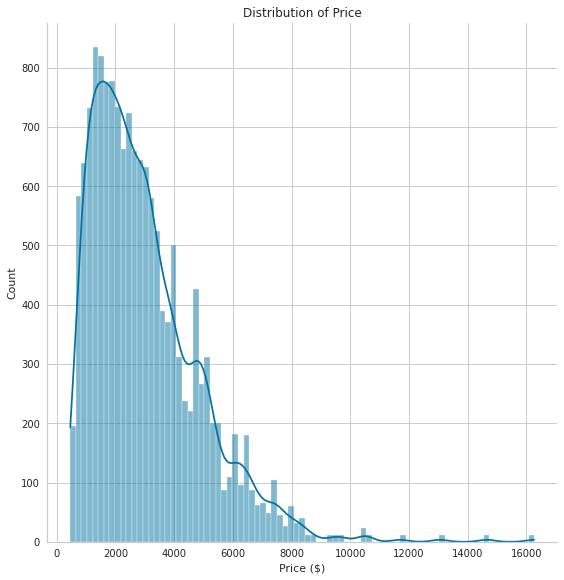

In [22]:
sns.displot(data=pcDf, x="Price ($)", kde=True, height = 8)
plt.title("Distribution of Price")
plt.show()

In [23]:
price_median = pcDf["Price ($)"].median()
price_iqr = pcDf["Price ($)"].quantile(.75) - pcDf["Price ($)"].quantile(.25)
print(f"Median Price: ${price_median}, Price IQR: ${price_iqr}")

Median Price: $2614.426, Price IQR: $2376.6440000000002


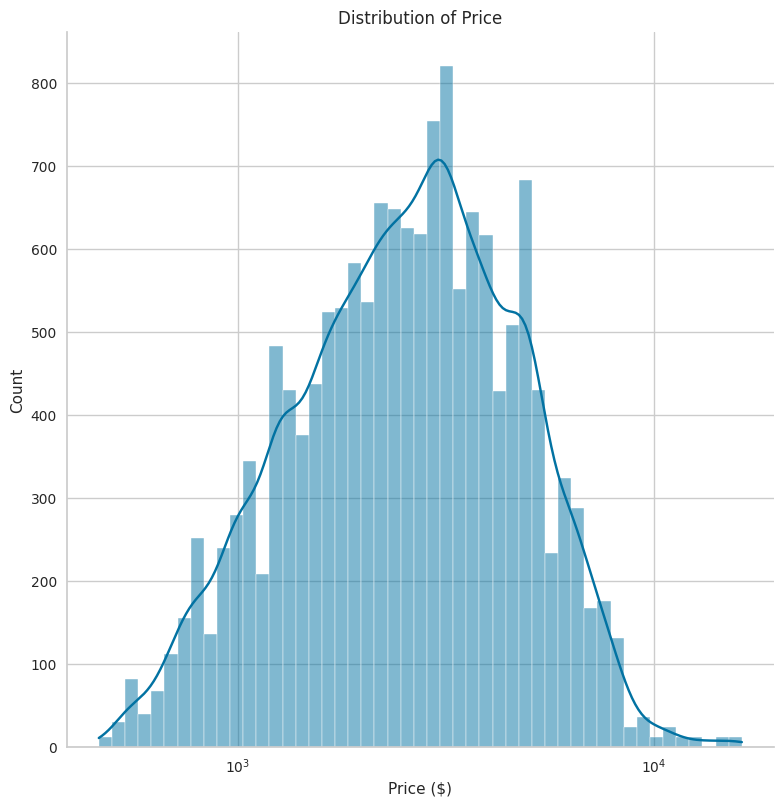

In [24]:
sns.displot(data=pcDf, x="Price ($)", kde=True, height = 8,log_scale=True)
plt.title("Distribution of Price")
plt.show()

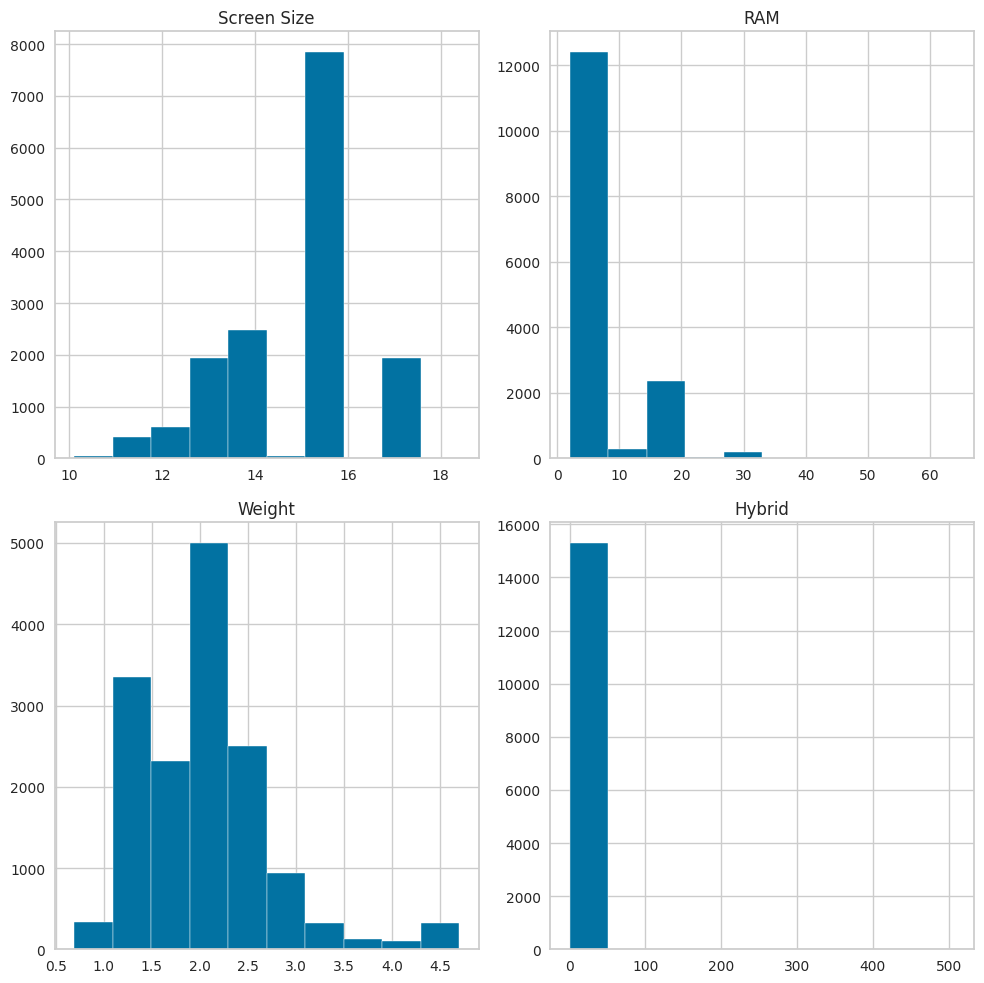

In [25]:
pcDf[quantitativeVariable].hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

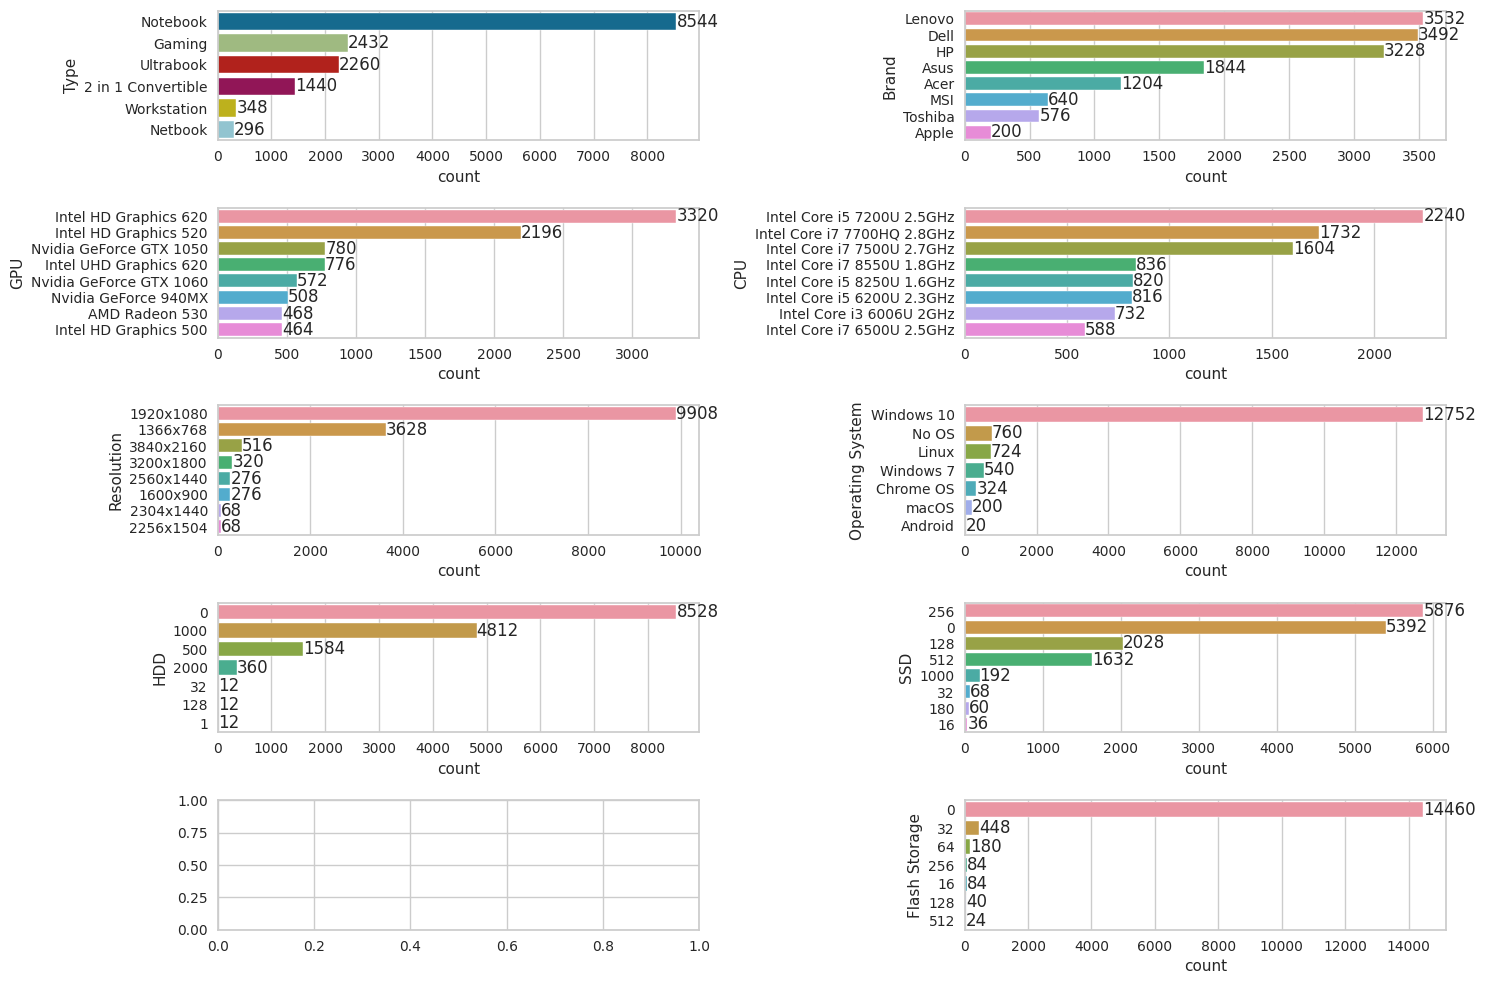

In [26]:
fig, ax = plt.subplots(int(np.ceil(len(qualitativeVariable)/2)), 2, figsize=(15, 10), tight_layout=True)
for i,y in enumerate(qualitativeVariable):
    n=1 if i%2==0 else 0
    g=sns.countplot(y=y,data=pcDf,ax=ax[int(np.floor(i/2)),n],orient='h',order=pcDf[y].value_counts().iloc[:8].index)
    g.bar_label(g.containers[0])
fig.show()

In [27]:
pcDf

,Product ID,Brand,Type,Screen Size,CPU,RAM,GPU,Operating System,Weight,Price ($),SSD,Flash Storage,HDD,Hybrid,Resolution,Touchscreen
0,0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,3568.93416,128,0,0,0,2560x1600,0
1,1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,2394.77616,0,128,0,0,1440x900,0
2,2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,1531.80000,256,0,0,0,1920x1080,0
3,3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,6759.76680,512,0,0,0,2880x1800,0
4,4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,4804.79040,256,0,0,0,2560x1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,15315,Lenovo,2 in 1 Convertible,14.0,Intel Core i7 6500U 2.5GHz,4,Intel HD Graphics 520,Windows 10,1.80,1706.40200,128,0,0,0,1920x1080,1
15316,15316,Lenovo,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16,Intel HD Graphics 520,Windows 10,1.30,4000.10600,512,0,0,0,3200x1800,1
15317,15317,Lenovo,Notebook,14.0,Intel Celeron Dual Core N3050 1.6GHz,2,Intel HD Graphics,Windows 10,1.50,616.82600,0,64,0,0,1366x768,0
15318,15318,HP,Notebook,15.6,Intel Core i7 6500U 2.5GHz,6,AMD Radeon R5 M330,Windows 10,2.19,2042.06600,0,0,1000,0,1366x768,0


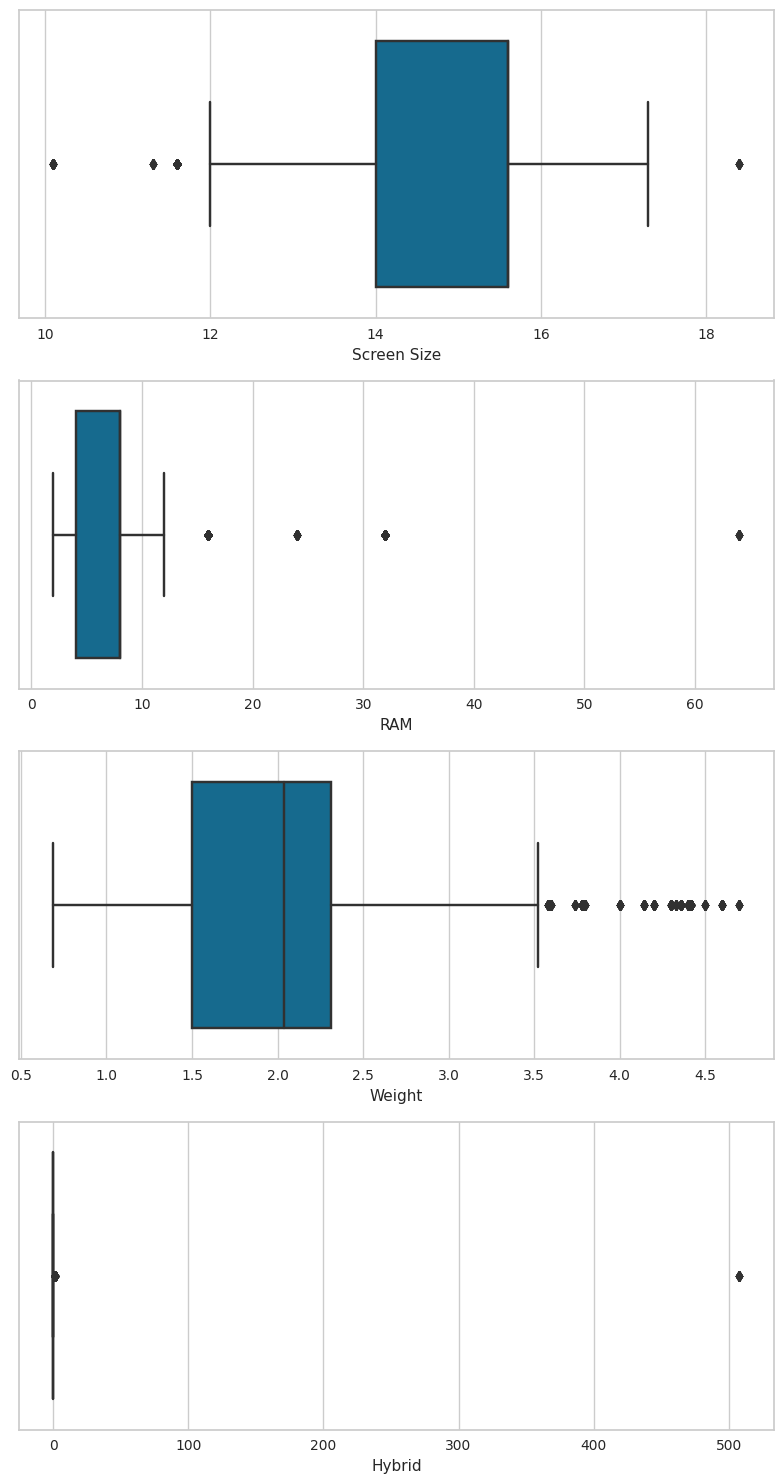

In [28]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):
    sns.boxplot(data=pcDf, x=feature, ax = ax[idx])
fig.show()

### Bivariate Analysis

In [29]:
pcDf=pcDf.drop('Product ID',axis=1)


interval columns not set, guessing: ['Screen Size', 'RAM', 'Weight', 'Price ($)', 'SSD', 'Flash Storage', 'HDD', 'Hybrid', 'Touchscreen']


Text(0.5, 1.0, 'Correlation Matrix')

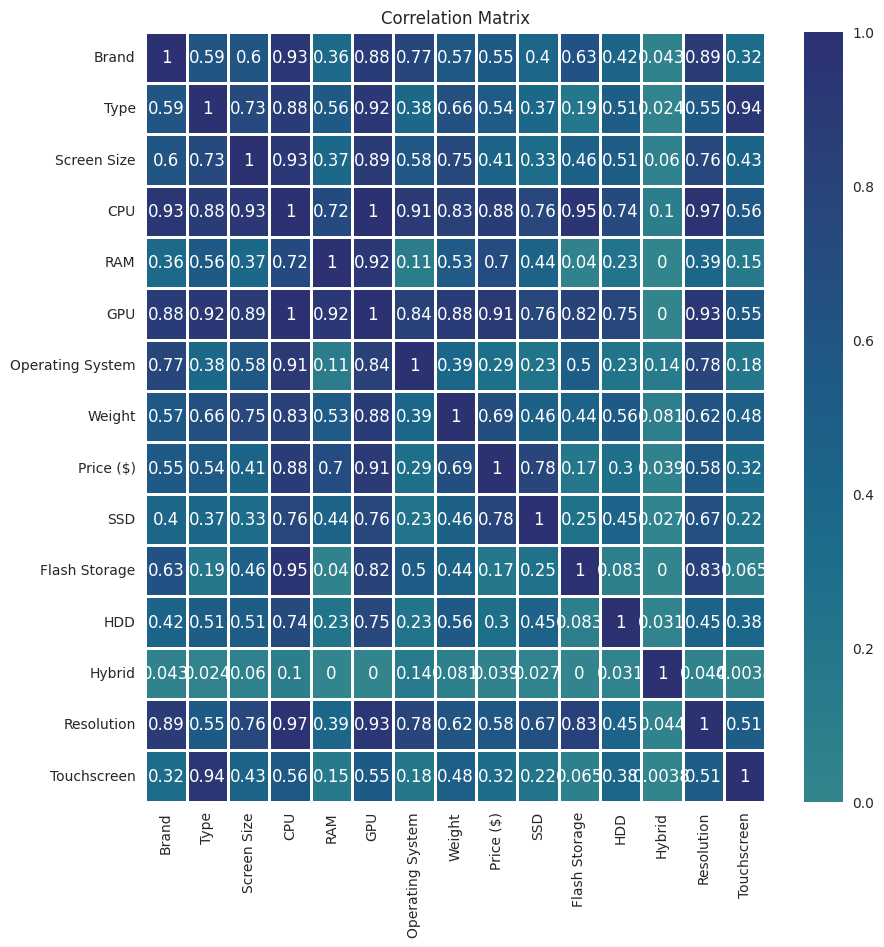

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
# corr_matrix = pcDf.phik_matrix(interval_cols=pcDf.columns)
corr_matrix =pcDf.phik_matrix()
sns.heatmap(corr_matrix, annot = True, linewidths=.8,center = 0,cmap="crest").set_title('Correlation Matrix')

In [31]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [32]:
vifdf=pcDf.copy()
#Label Encoding on the Package attribute
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
#Assigning numerical values and storing in another column
vif=MultiColumnLabelEncoder(columns = qualitativeVariable).fit_transform(vifdf)


vif[quantitativeVariable]=StandardScaler().fit_transform(vif[quantitativeVariable])

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [26]:
calc_vif(vif)

,variables,VIF
0,Product ID,3.816080
1,Brand,3.666061
2,Type,7.773916
3,Screen Size,3.950408
4,CPU,17.067639
5,RAM,2.661220
6,GPU,11.212883
7,Operating System,23.272179
8,Weight,4.672511
9,Price ($),12.738322


#### Seperate Target and Features


In [34]:
x,y=pcDf.drop('Price ($)',axis=1),pcDf['Price ($)']


#### Training Set and Test Set

In [35]:
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.2,shuffle=True,random_state=42)

### Feature Selection

In [29]:
import pandas as pd

from category_encoders import HashingEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from category_encoders.one_hot import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector

# def featureSelection(X,y,n='all',cv=5):
#     class converter():
#         def __init__(self):
#             super().__init__()

#         def fit_transform(self, X, y=None):
#             return self.transform(X=X, y=y)

#         def transform(self, X, y=None):
#             return pd.DataFrame(X)

#         def fit(self, X, y=None):
#             return self
#     def get_pipeline():

#         preprocessor = ColumnTransformer(transformers=[
#             ('Hashing Encoding', HashingEncoder(n_components=32,cols=None), make_column_selector(dtype_exclude="number"))
#         ], remainder="passthrough")

#         clf = Pipeline(steps=[
#             ## Column selector requires a dataframe while Column Tranformer returns a np array
#             ('df_converter', converter()),
#             ('Hashing',preprocessor),
#             ('classifier', XGBRegressor(n_jobs=-1))
#         ])

#         return clf

#     if (n=='all'):
#         n=len(X.columns)
#         print(n)
#     record=pd.DataFrame({'score':[],'best':[],'no':[]})
#     for i in range(1,n+1):
#         print(i)
#         sfs=SequentialFeatureSelector(get_pipeline(),
#                k_features=i,
#                forward=True,
#                floating=False,
#                scoring='mean_absolute_error',
#                cv=cv).fit(X, y)
#         record=pd.concat([record,pd.DataFrame({'score':[sfs.k_score_],'best':[sfs.k_feature_names_],'no':[i]})],ignore_index=True)

#     return record

In [ ]:
# featureEvaluation=featureSelection(x_train,y_train)
# featureEvaluation

In [ ]:
# sns.lineplot(x='no',y='score',data=featureEvaluation)

In [ ]:
# featureSelected=np.array(featureEvaluation.best[11])

In [30]:
featureSelected=['Screen Size','Weight','RAM','Brand','Type','CPU','GPU','Operating System','SSD','Flash Storage','Resolution','HDD']
x_train=x_train[featureSelected]
x_test=x_test[featureSelected]

In [31]:
x_train

,Screen Size,Weight,RAM,Brand,Type,CPU,GPU,Operating System,SSD,Flash Storage,Resolution,HDD
8217,17.3,2.80,6,Lenovo,Notebook,Intel Core i7 7500U 2.7GHz,Nvidia GeForce 940MX,Windows 10,128,0,1600x900,1000
4093,15.6,2.18,4,Dell,Notebook,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,0,0,1920x1080,1000
15182,15.6,2.62,8,Dell,Gaming,Intel Core i7 7700HQ 2.8GHz,Nvidia GeForce GTX 1050 Ti,Windows 10,128,0,3840x2160,1000
15014,15.6,2.40,4,Acer,Notebook,Intel Pentium Quad Core N4200 1.1GHz,Intel HD Graphics 505,Windows 10,0,0,1366x768,500
12629,15.6,1.88,8,HP,Ultrabook,Intel Core i7 6500U 2.5GHz,Intel HD Graphics 520,Windows 7,256,0,1920x1080,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5191,17.3,2.43,16,MSI,Gaming,Intel Core i7 7700HQ 2.8GHz,Nvidia GeForce GTX 1070,Windows 10,256,0,1920x1080,2000
13418,15.6,2.20,8,Lenovo,Notebook,Intel Core i7 7500U 2.7GHz,Nvidia GeForce 920MX,Windows 10,0,0,1920x1080,1000
5390,17.3,2.90,16,HP,Notebook,Intel Core i7 8550U 1.8GHz,Nvidia GeForce MX150,Windows 10,0,0,1920x1080,1000
860,15.6,2.30,8,Lenovo,Notebook,Intel Core i5 7200U 2.5GHz,Intel HD Graphics 620,Windows 10,0,0,1920x1080,1000


### Feature  Scaling

In [38]:
import category_encoders
from category_encoders.hashing import HashingEncoder
from sklearn.compose import make_column_selector

quantitativeTransformer=Pipeline([
     ('StandardScaler',StandardScaler())
])
categorical_transformers = Pipeline([
    ('Hashing Encoder', HashingEncoder(max_process=1))
])
data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', quantitativeTransformer, make_column_selector(dtype_include='number')),
       ('Preprocess Categorical Features', categorical_transformers,make_column_selector(dtype_exclude='number'))
])


## Evaluation

In [40]:
def scoreModel(clf,x,y,algName=None,record=pd.DataFrame({'name':[],'train_neg_mean_absolute_error':[],'test_neg_mean_absolute_error':[],'train_neg_mean_absolute_percentage_error':[],
 'test_neg_mean_absolute_percentage_error':[],
 'train_neg_root_mean_squared_error':[],
 'test_neg_root_mean_squared_error':[]
                                                 })):
    '''
    This function is used for model evaluation . This function use scikit-learn library to carry out cross validation using StratifiedKFold.

    :param clf: Classifier 分类器
    :param x:Train Data X(Data)  训练数据 （数据）
    :param y:Train Data Y(Result)  训练数据（结果）
    :param algName: Name of Algorithm used for recording 算法名字
    :param record: History record dataframe 在历史记录上叠加结果
    :return:
    This function return 3 variable: 这个函数返回三个参数
    record: Dataframe with current and past record(if there is any)
    current: Dataframe with current record
    lr: Learning curve
    '''
    score=cross_validate(clf,x,y,cv=KFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"],n_jobs=-1,return_estimator=True,return_train_score=True)

    current=pd.DataFrame({'name':[algName],'train_neg_mean_absolute_error':score['train_neg_mean_absolute_error'].mean(),'test_neg_mean_absolute_error':score['test_neg_mean_absolute_error'].mean(),'train_neg_mean_absolute_percentage_error':score['train_neg_mean_absolute_percentage_error'].mean(),'test_neg_mean_absolute_percentage_error':score['test_neg_mean_absolute_percentage_error'].mean(),
     'traing_neg_root_mean_squared_error':score['train_neg_root_mean_squared_error'].mean(),
         'test_neg_root_mean_squared_error':score['test_neg_root_mean_squared_error'].mean(),
                          })
    record=pd.concat([record,current],ignore_index=True)
    lr = learning_curve(clf, x, y, scoring = 'neg_mean_absolute_error', cv = KFold(n_splits = 5, shuffle = True, random_state = 0,), n_jobs=-1)
    return record,current,lr

In [44]:
def func(x):
     return np.log(x)
def inverse_func(x):
     return np.exp(x)

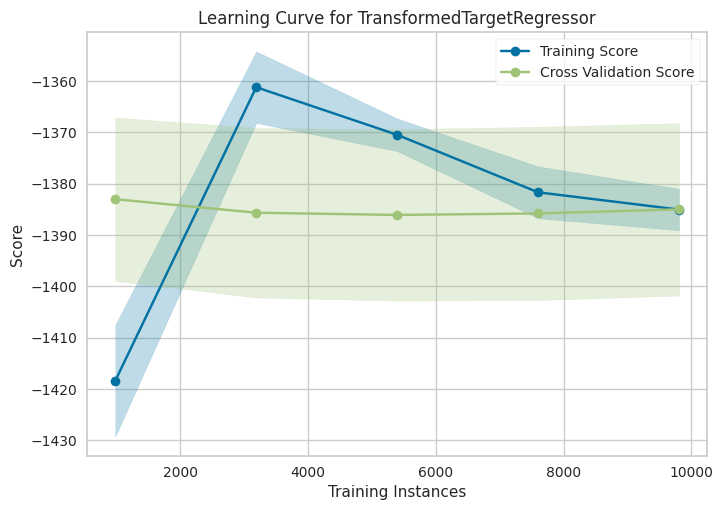

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,Baseline,-1384.923138,-1384.972964,-0.58425,-0.584298,-1908.213895,-1908.209499


In [45]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', TransformedTargetRegressor(regressor=DummyRegressor(),func=func, inverse_func=inverse_func))
])

record, scores, lr = scoreModel(baseline, x_train, y_train, algName="Baseline")
scores

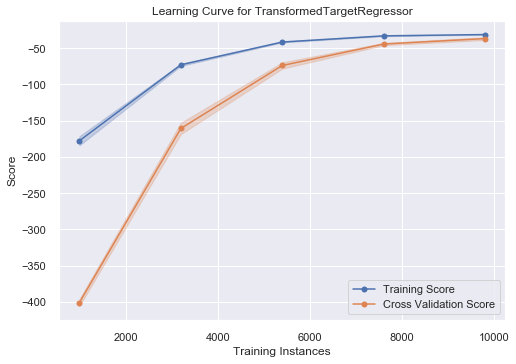

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,Random Forest Regressor,-31.145878,-36.939996,-0.012644,-0.01486,-116.584026,-129.593057


In [39]:
rf = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=RandomForestRegressor(criterion='absolute_error',n_jobs=-1),func=func, inverse_func=inverse_func)),

])

record,scores, lr = scoreModel(rf, x_train, y_train, algName="Random Forest Regressor", record=record)
scores

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


parameter={'Model__max_depth':np.arange(9,30),'Model__ccp_alpha':np.arange(0.0027,0.0127,0.002)}
pd.DataFrame(HalvingGridSearchCV(rf,param_grid=parameter,scoring='neg_mean_absolute_error',n_jobs=-1).fit(x_train,y_train).cv_results_)

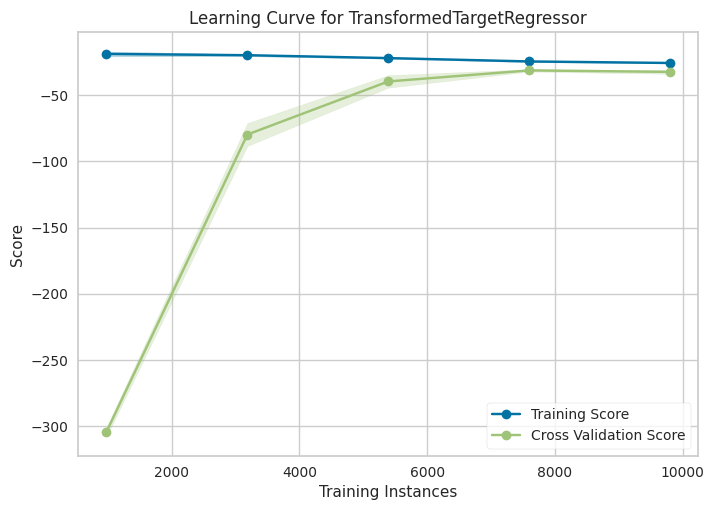

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,Extra Tree Regressor,-25.832868,-32.567432,-0.010407,-0.013086,-126.715846,-143.181763


In [47]:
ex = Pipeline([
    ('Data Preprocessing', data_preprocessing),
     ('Log',TransformedTargetRegressor(regressor=ExtraTreesRegressor(criterion='absolute_error',n_jobs=-1),func=func, inverse_func=inverse_func)),
])
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


# parameter={'Model__max_depth':np.arange(2,30),'Model__ccp_alpha':np.arange(0.0027,0.0427,0.002),'Model__n_estimators':np.arange(10,150,10)}
# pd.DataFrame(HalvingGridSearchCV(ex,param_grid=parameter,scoring='neg_mean_absolute_error',n_jobs=-1).fit(x_train,y_train).cv_results_)
record,scores, lr = scoreModel(ex, x_train, y_train, algName="Extra Tree Regressor", record=record)
scores

/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1854: FutureWar

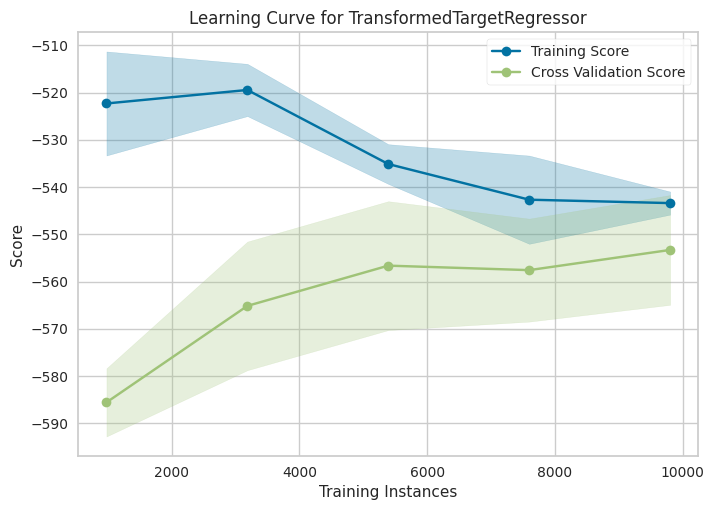

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,Gradient Boosting Regressor,-542.176701,-551.72542,-0.19806,-0.201681,-830.787919,-843.734702


In [48]:
gbm = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=GradientBoostingRegressor(criterion='absolute_error'),func=func, inverse_func=inverse_func)),
])

record,scores, lr = scoreModel(gbm, x_train, y_train, algName="Gradient Boosting Regressor", record=record)
scores

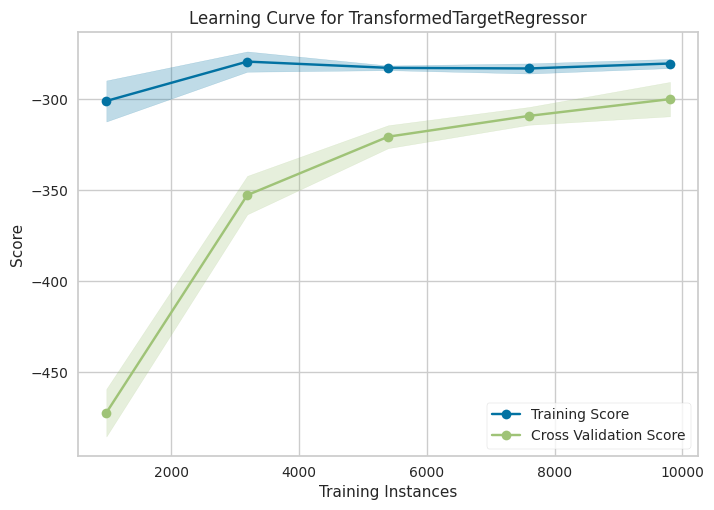

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,HistGradient Boosting Regressor,-280.268087,-298.256048,-0.098348,-0.104968,-425.399266,-453.002107


In [55]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgbm = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(),func=func, inverse_func=inverse_func)),
])

record,scores, lr = scoreModel(hgbm, x_train, y_train, algName="HistGradient Boosting Regressor", record=record)
scores

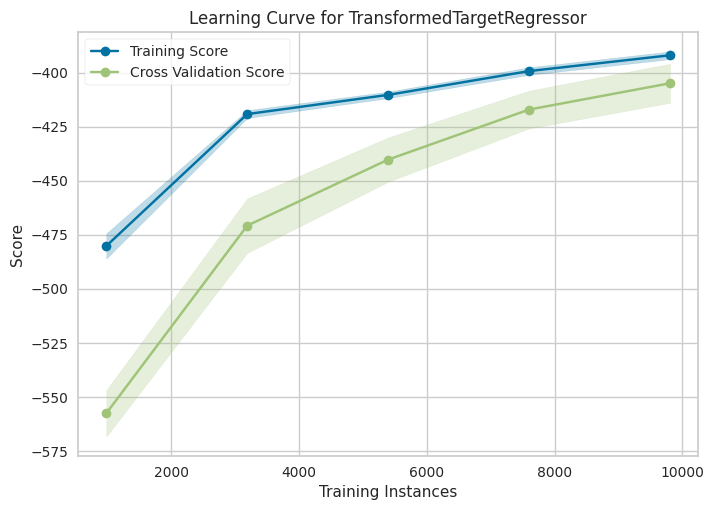

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,Support Vector Regressor,-391.976411,-404.939754,-0.143979,-0.149059,-561.876766,-580.461162


In [49]:
from sklearn.svm import SVR

svr = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=SVR(criterion='absolute_error'),func=func, inverse_func=inverse_func)),


])



# parameter={'Model__C':np.arange(2,15)}
# pd.DataFrame(HalvingGridSearchCV(svr,param_grid=parameter,scoring='neg_mean_absolute_error',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,scores, lr = scoreModel(svr, x_train, y_train, algName="Support Vector Regressor", record=record)
scores

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

knn = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=KNeighborsRegressor(),func=func, inverse_func=inverse_func)),
])


# parameter={'Model__n_neighbors':np.arange(1,15)}
# pd.DataFrame(HalvingGridSearchCV(knn,param_grid=parameter,scoring='neg_mean_absolute_error',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,scores, lr = scoreModel(knn, x_train, y_train, algName="k-Nearest Neighbor Regressor", record=record)
scores

[13:11:23] WARNING: ../src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:11:24] WARNING: ../src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:11:25] WARNING: ../src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

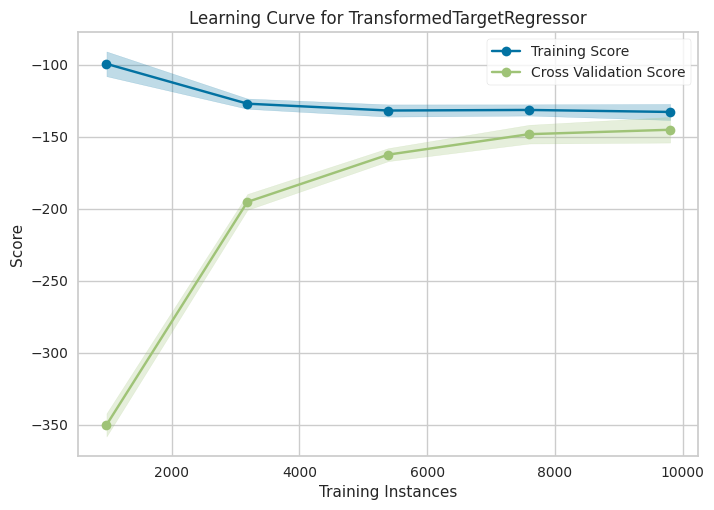

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,traing_neg_root_mean_squared_error,test_neg_root_mean_squared_error
0,eXtreme Gradient Boosting Regressor,-132.220192,-144.539917,-0.048954,-0.053345,-217.715297,-239.199707


In [52]:
from xgboost import XGBRegressor
xgb = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Log',TransformedTargetRegressor(regressor=XGBRegressor(),func=func, inverse_func=inverse_func)),
])
# parameter={'Model__max_depth':np.arange(1,15),'Model__n_estimators':np.arange(0,100,5),'Model__learning_rate':np.arange(0.1,2,0.1)}
# pd.DataFrame(HalvingGridSearchCV(xgb,param_grid=parameter,scoring='neg_mean_absolute_error',n_jobs=-1).fit(x_train,y_train).cv_results_)
record,scores, lr = scoreModel(xgb, x_train, y_train, algName="eXtreme Gradient Boosting Regressor", record=record)
scores

In [53]:
record

,name,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error,traing_neg_root_mean_squared_error
0,Baseline,-1384.923138,-1384.972964,-0.584250,-0.584298,NaN,-1908.209499,-1908.213895
1,Extra Tree Regressor,-25.832868,-32.567432,-0.010407,-0.013086,NaN,-143.181763,-126.715846
2,Gradient Boosting Regressor,-542.176701,-551.725420,-0.198060,-0.201681,NaN,-843.734702,-830.787919
3,Support Vector Regressor,-391.976411,-404.939754,-0.143979,-0.149059,NaN,-580.461162,-561.876766
4,Adaptive Boosting Regressor,-723.753104,-724.704625,-0.265399,-0.265975,NaN,-1021.360283,-1019.606923
5,eXtreme Gradient Boosting Regressor,-132.220192,-144.539917,-0.048954,-0.053345,NaN,-239.199707,-217.715297
6,eXtreme Gradient Boosting Regressor,-132.220192,-144.539917,-0.048954,-0.053345,NaN,-239.199707,-217.715297
